# Sampler

> Toolbox to emulate data collection

In [ ]:
#| default_exp sampler

In [ ]:
#| hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import rasterio
from rasterio import transform
import fastcore.all as fc
import matplotlib.pyplot as plt
from trufl.utils import reproject_raster
import geopandas as gpd
from typing import List

In [ ]:
#| hide
from trufl.utils import gridder
red, black = '#BF360C', '#263238'

In [ ]:
#|export
class Sampler:
    def __init__(self, 
               fname_raster:str, # The path to the raster file.
               band:int=1, # The band number to use. Defaults to 1.
               id_name:str='loc_id'
               ):
        "Emulate data collection. Provided a set of location, return values sampled from given raster file."
        fc.store_attr()
        with rasterio.open(fname_raster) as src:
            self.band_data = src.read(band)
            self.affine = src.transform
            self.bounds = src.bounds

    def to_geodataframe(self, 
                        geoseries:gpd.GeoSeries, # The locations
                        values:List[float] # The sampled values
                        ) -> gpd.GeoDataFrame: 
        gdf = geoseries.to_frame(name='geometry').explode(index_parts=False)
        gdf = gdf.assign(value=values)
        return gdf.reset_index(names=self.id_name)
    
    def sample(self, 
               geoseries:gpd.GeoSeries # The locations
               ) -> gpd.GeoDataFrame:
        coords = [(x, y) for x, y in geoseries.get_coordinates().values]
        pixel_coords = [transform.rowcol(self.affine, *pair) for pair in coords]
        values = [self.band_data[int(x), int(y)] for (x, y) in pixel_coords]
        return self.to_geodataframe(geoseries, values)

How to use:

In [ ]:
#|eval: false
fname_raster = './files/ground-truth-02-4326-simulated.tif'
n_pts = 50
loc_id = 35

gdf_grid = gridder(fname_raster, nrows=10, ncols=10)
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs); gdf_samples.head()

,loc_id,geometry,value
0,35,POINT (-1.06340 43.18266),0.388978
1,35,POINT (-1.06214 43.17667),0.386318
2,35,POINT (-1.06107 43.17639),0.385351
3,35,POINT (-1.06067 43.19877),0.399131
4,35,POINT (-1.05956 43.17693),0.385882


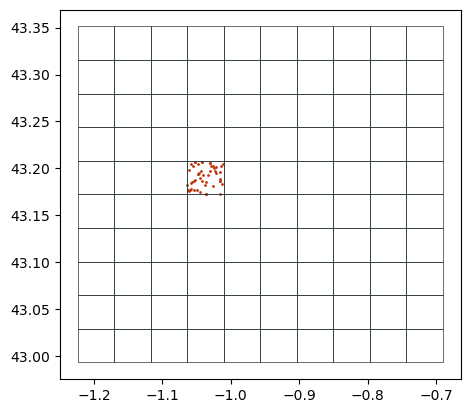

In [ ]:
#|eval: false
ax = gdf_samples.plot(markersize=1, c=red)
gdf_grid.boundary.plot(ax=ax, color=black, lw=0.5);

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()